In [4]:
%load_ext autoreload
%matplotlib widget
import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from tqdm.autonotebook import trange
from keras.datasets import mnist

%autoreload 1
%aimport jsi

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2024-04-02 17:30:22.551380: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-02 17:30:23.137628: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-02 17:30:23.984385: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/tmp/ipykernel_2589/2990024677.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange
2024-04-02 17:30

Num GPUs Available:  1


ead NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-02 17:30:26.354603: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7537 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


In [30]:
# training dataset generation
data_len = 100000

# Define a function to create a serialized tf.train.Example
def create_example(data, label):
    feature = {
        "data": tf.train.Feature(float_list=tf.train.FloatList(value=data.flatten())),
        "label": tf.train.Feature(float_list=tf.train.FloatList(value=label)),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

# Write examples to a TFRecord file
filename = "100k_sqrt_noise.tfrecord"
with tf.io.TFRecordWriter(filename) as writer:
    for i in trange(data_len):
        js = np.random.uniform(low=0.0, high=1, size=(3, 5))
        phis = np.random.uniform(low=0.0, high=2*np.pi, size=(3, 5))
        loss = np.random.uniform(low=0.1, high=0.5, size=(2, 3, 28*2))
        g = np.random.uniform(low=0.0, high=0.05)
        input = {
            'nodes' : 28,
            'padding' : 0,
            'n_rings' : 3,
            'orth_itr' : 1,
            'length': 5,
            'js': np.array(js * np.exp(1j * phis), dtype=np.complex64), 
            'jr': np.array(loss[0], dtype=np.complex64), 
            'g': np.array([g], dtype=np.complex64), 
            'y0s': np.array(loss[1], dtype=np.complex64) 
        }
        _, _, output = jsi.jsi_backprop(input, train=False)
        # try:
        #     plt.close(fig)
        # except:
        #     pass
        # fig=jsi.pltSect(output, 0, 0, 28, 28)
        if np.isnan(output).any():
            data_len += 1
            continue
        output_norm = np.abs(output) / np.max(np.abs(output))
        example = create_example(output_norm, np.concatenate((js.flatten(), phis.flatten(), loss.flatten(), [g]), axis=0))
        writer.write(example.SerializeToString())


  0%|          | 0/100000 [00:00<?, ?it/s]

In [55]:
# training dataset generation
data_len = 100000

# Define a function to create a serialized tf.train.Example
def create_example(data, label):
    feature = {
        "data": tf.train.Feature(float_list=tf.train.FloatList(value=data.flatten())),
        "label": tf.train.Feature(float_list=tf.train.FloatList(value=label)),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

# Write examples to a TFRecord file
filename = "random.tfrecord"
with tf.io.TFRecordWriter(filename) as writer:
    for i in trange(data_len):
        output_norm = np.random.uniform(size=(28, 28))
        example = create_example(output_norm, [])
        writer.write(example.SerializeToString())

  0%|          | 0/100000 [00:00<?, ?it/s]

In [ ]:
# Read from TFRecord file
# Create a dataset from the TFRecords file
dataset = tf.data.TFRecordDataset(["my_dataset.tfrecord"])

# Define the feature description (adjust shapes and types as needed)
feature_description = {
    'data': tf.io.FixedLenFeature([28*28], tf.float32),
    'label': tf.io.FixedLenFeature([3*5*2+2*3*28*2+1], tf.float32)
}

# Parse the serialized example
def _parse_function(example_proto):
    return tf.io.parse_single_example(example_proto, feature_description)

# Apply the parsing function to each example
parsed_dataset = dataset.map(_parse_function)

# Process the data
try:
    for example in parsed_dataset:
        data, label = example['data'], example['label']
        print("data: ", len(data))
        print("label: ", len(label))
except tf.errors.OutOfRangeError:
    print("Finished reading data.")

In [99]:
# training using cnn
input = {
    'nodes' : 28,
    'padding' : 0,
    'n_rings' : 5,
    'orth_itr' : 1,
    'length': 5
}
model = jsi.jsi_conv(input, "mnist", epochs=1)
model.save('./models/mnist_e1.keras')

3750/3750 [==============================] - ETA: 0s - loss: 0.4531INFO:tensorflow:Assets written to: ./nn_chkpt/assets


INFO:tensorflow:Assets written to: ./nn_chkpt/assets


3750/3750 [==============================] - 7383s 2s/step - loss: 0.4531


In [100]:
# additional training
input['model'] = model
model = jsi.jsi_conv(input, "random.tfrecord", epochs=1)
model.save('./models/mnist_e1.keras')

   6250/Unknown - 12180s 2s/step - loss: 0.2444

2024-04-05 17:40:03.045477: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 17537429461107040827
2024-04-05 17:40:03.045580: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 6204783107692006161
2024-04-05 17:40:03.045665: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 17016002942494217403
2024-04-05 17:40:03.045672: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 6926279090687591023
2024-04-05 17:40:03.045676: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 8267850970293487467
2024-04-05 17:40:03.045680: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 11425224034600095348
2024-04-05 17:40:03.045712: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv 

INFO:tensorflow:Assets written to: ./nn_chkpt/assets


INFO:tensorflow:Assets written to: ./nn_chkpt/assets


6250/6250 [==============================] - 12195s 2s/step - loss: 0.2444


In [89]:
# Load model from keras file
model = tf.keras.models.load_model('./models/mnist_e15.keras')

In [94]:
# Load model from checkpoint directories
model = tf.keras.models.load_model('./nn_chkpt')

1/1 [==============================] - 0s 35ms/step


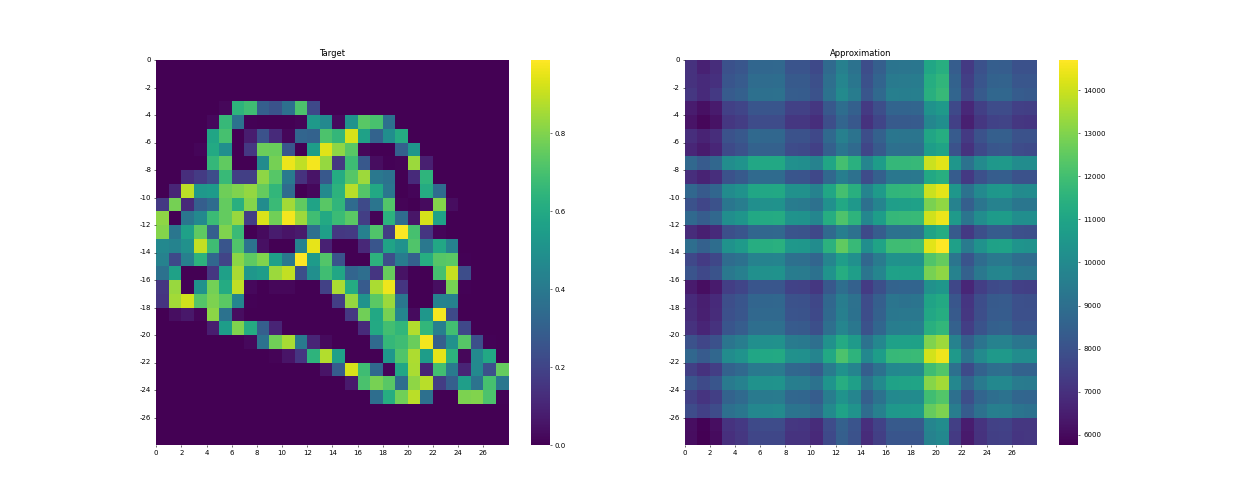

In [103]:
import cv2

duck = cv2.imread('duck_pix.png', cv2.IMREAD_UNCHANGED)
duck = cv2.resize(duck, dsize=(28, 28), interpolation=cv2.INTER_LINEAR)[:, :, -1] / 255

rand = np.random.uniform(size=(28, 28))

nodes = 28
n_rings = 5
length = 5
padding = 0
kernel = jsi.JsiKernel(nodes, padding, n_rings, length)

pred = model.predict(tf.constant([duck, rand]))
output = kernel.call_flat(pred[0])
try:
    plt.close(fig)
except:
    pass
fig = jsi.pltCtst(duck, output, 0, 0, 28, 28)

313/313 [==============================] - 1s 2ms/step
(10000, 28, 28)
tf.Tensor(
[[ 0.04742497-5.2943556e-03j -0.04147914+8.9442125e-03j
   0.03643647-5.0350609e-03j -0.03292268+1.0954245e-03j
   0.02280902+2.8022558e-03j]
 [-0.03479267+6.8239268e-04j -0.0558438 +5.4706368e-03j
  -0.02879778+8.3100627e-04j -0.00908684-6.7408098e-04j
   0.07218461+6.6081514e-03j]
 [ 0.08939256-2.5273024e-03j  0.00312066+8.8165849e-05j
  -0.00289525+4.3372205e-05j -0.01089828-6.7928276e-04j
  -0.00249004-9.2055896e-05j]
 [ 0.04514101+1.5238069e-04j -0.01225118-4.4740902e-04j
   0.02189907-2.0474417e-03j -0.05792897+3.3779382e-03j
   0.01959556-1.5730177e-03j]
 [ 0.01120671+2.6197289e-04j  0.01037434-5.5488904e-06j
   0.0207595 +1.0264558e-03j  0.02041765+5.4448860e-04j
  -0.04661034+9.1722497e-04j]], shape=(5, 5), dtype=complex64)


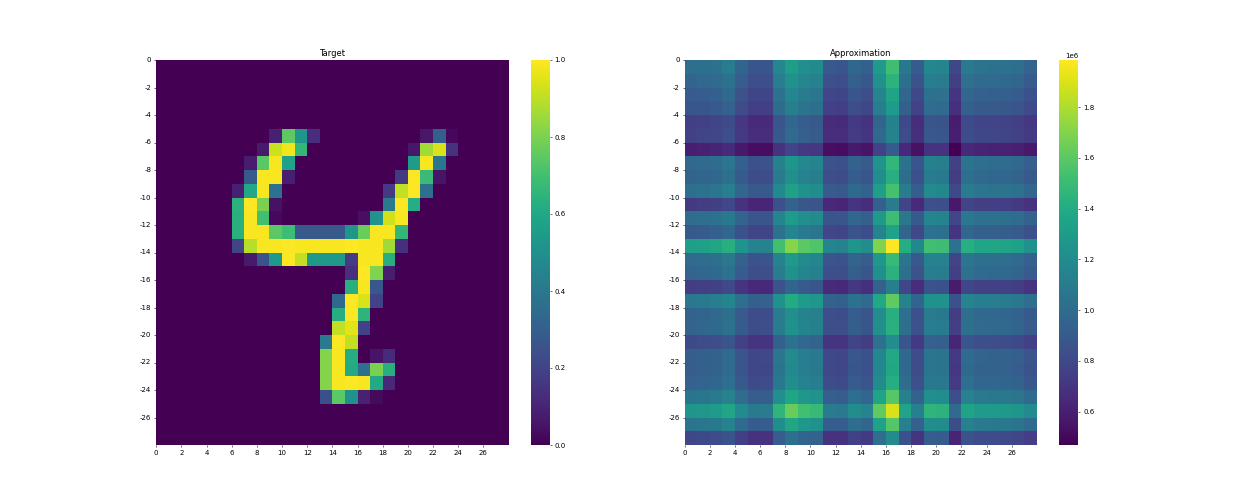

In [104]:
# verify against mnist data
# index of the mnist model
index = 6

(train_X, train_y), (test_X, test_y) = mnist.load_data()

pred = model.predict(test_X / 255)
print(test_X.shape)
nodes = 28
n_rings = 5
length = 5
padding = 0
nodes_t = nodes + 2 * padding
input = {
    'nodes' : nodes,
    'padding' : padding,
    'n_rings' : n_rings,
    'orth_itr' : 10,
    'length': length,
    'js': tf.cast(tf.reshape(pred[index][0:n_rings * length], (n_rings, length)), dtype=tf.complex64) * tf.exp(1j * tf.cast(tf.reshape(pred[index][n_rings * length:n_rings * length * 2], (n_rings, length)), dtype=tf.complex64)), 
    'jr': tf.cast(tf.reshape(pred[index][n_rings*length*2 : n_rings*length*2+nodes_t*2*n_rings], (n_rings, nodes_t*2)), dtype=tf.complex64), 
    'g': tf.cast(pred[index][-1], dtype=tf.complex64), 
    'y0s': tf.cast(tf.reshape(pred[index][n_rings*length*2+nodes_t*2*n_rings:n_rings*length*2+nodes_t*4*n_rings], (n_rings, nodes_t*2)), dtype=tf.complex64)
}
print(input['js'])
_, _, output = jsi.jsi_backprop(input, train=False)
try:
    plt.close(fig)
except:
    pass
fig = jsi.pltCtst(test_X[index] / 255, output, 0, 0, 28, 28)

1/1 [==============================] - 0s 65ms/step
[[ 0.02280674+3.20454710e-04j -0.00965372-1.62608019e-04j
   0.00208065-1.94166987e-05j -0.00021906+3.08451327e-08j
   0.00139159+2.40655709e-06j]
 [-0.00929648+3.69102811e-04j -0.00786092+1.14840674e-04j
  -0.00227229+4.20775061e-04j  0.01356955+1.64773286e-04j
   0.00199577+2.19785492e-04j]
 [ 0.00207699-1.18379772e-04j -0.01612393-5.72204415e-04j
  -0.01421094+6.63397426e-04j  0.01530916+1.09554014e-04j
  -0.00991191-3.85979110e-05j]]


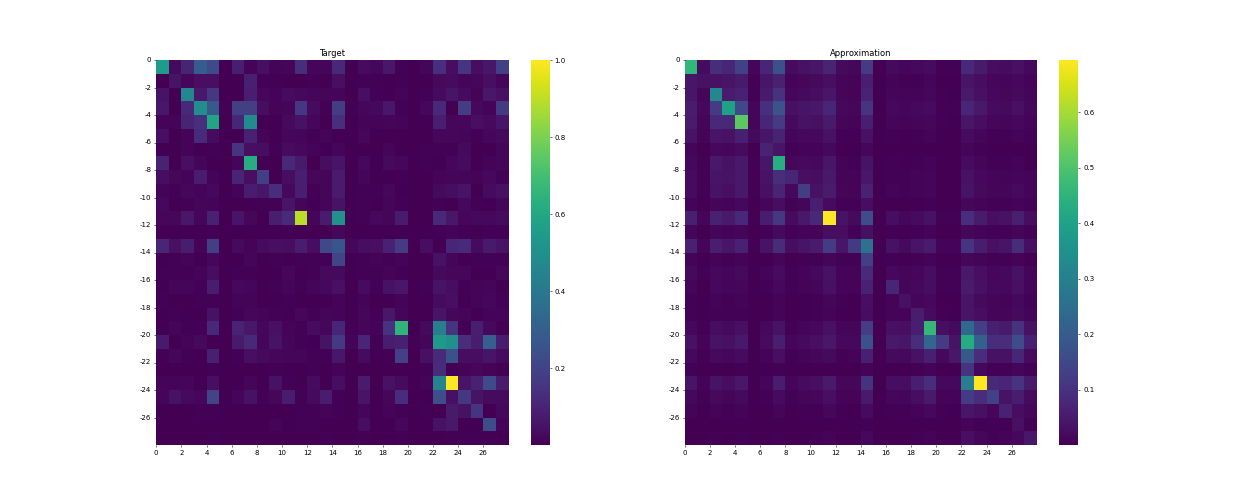

In [7]:
# verify against jsi generated with some constraint

js = np.random.uniform(low=0.0, high=1, size=(3, 5))
phis = np.random.uniform(low=0.0, high=2*np.pi, size=(3, 5))
loss = np.random.uniform(low=0.0, high=0.5, size=(2, 3, 28*2))
g = np.random.uniform(low=0.0, high=0.1)
# loss = np.ones((2, 3, 28*2)) / 10
# g = 0.03
input = {
    'nodes' : 28,
    'padding' : 0,
    'n_rings' : 3,
    'orth_itr' : 10,
    'length': 5,
    'js': np.array(js * np.exp(1j * phis), dtype=np.complex64), 
    'jr': np.array(loss[0], dtype=np.complex64), 
    'g': np.array([g], dtype=np.complex64), 
    'y0s': np.array(loss[1], dtype=np.complex64) 
}
_, _, output = jsi.jsi_backprop(input, train=False)
target = np.abs(output) / np.max(np.abs(output))

index = 0
pred = model.predict(np.array([target]))

input = {
    'nodes' : 28,
    'padding' : 0,
    'n_rings' : 3,
    'orth_itr' : 10,
    'length': 5,
    'js': np.array(pred[index][0:15].reshape((3, 5)) * np.exp(1j * pred[index][15:30].reshape((3, 5))), dtype=np.complex64), 
    'jr': np.array(pred[index][30:198].reshape((3, 56)), dtype=np.complex64), 
    'g': np.array([pred[index][-1]], dtype=np.complex64), 
    'y0s': np.array(pred[index][198:366].reshape((3, 56)), dtype=np.complex64) 
}
print(input['js'])
_, _, output = jsi.jsi_backprop(input, train=False)
try:
    plt.close(fig)
except:
    pass
fig = jsi.pltCtst(target, output, 0, 0, 28, 28)